# Training PPO Agent in GridWorld3D-v0 Environment


------------------------------


## Importing required libraries

In [1]:
from __future__ import annotations
import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import gymnasium as gym
from gymnasium.wrappers import FlattenObservation

import gymnasium_env
import agents
from gymnasium_env import wrappers

In [2]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

## Dummy Example of GrdWorldEnv Dynamics

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium_env.wrappers.clip_reward import ClipReward

env = gym.make("GridWorld3D-v0", max_episode_steps=400)
env = FlattenObservation(env)
env = RecordEpisodeStatistics(env)

print(env)
num_episodes = 1

for episode in range(num_episodes):
    obs, info = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = env.action_space.sample()  # oppure il tuo agente
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1

        print(f"Step {steps}: Distance to target: {info['distance']:.2f}")
        print(reward)

    print(f"Episode {episode+1}: Total reward = {total_reward:.2f}, Steps = {steps}")
    print(f"  Stats: {env.return_queue[-1]} reward, {env.length_queue[-1]} steps")


# Proximal Policy Optimization Tutorial

## Create and initialitize environment hyperparameters

In [3]:
print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "GridWorld3D-v0"
has_continuous_action_space = True

max_ep_len = 600                    # max timesteps in one episode
max_training_timesteps = int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e3)  # action_std decay frequency (in num timesteps)

#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = gym.make(env_name)

# flattening the obs space 
env = FlattenObservation(env)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

training environment name : GridWorld3D-v0


### Print Environment Spaces

In [4]:
# Access the observation space of the wrapped environment
obs_space = env.observation_space
print("Observation space:", obs_space)
print("Observation shape:", state_dim)

# Access the action space of the wrapped environment
action_space = env.action_space
print("Action space:", action_space)
print("Observation shape:", action_dim)


Observation space: Box(0.0, 50.0, (6,), float32)
Observation shape: 6
Action space: Box(-1.0, 1.0, (3,), float32)
Observation shape: 3


### Logging

In [5]:
###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################

current logging run number for GridWorld3D-v0 :  0
logging at : PPO_logs/GridWorld3D-v0//PPO_GridWorld3D-v0_log_0.csv


### Checkpointing

In [6]:
################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

####################################################

save checkpoint path : PPO_preTrained/GridWorld3D-v0/PPO_GridWorld3D-v0_0_0.pth


### Print all the hyperparameters 

In [7]:
############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  600
model saving frequency : 20000 timesteps
log frequency : 1200 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  6
action space dimension :  3
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  0.6
decay rate of std of action distribution :  0.05
minimum std of action distribution :  0.1
decay frequency of std of action distribution : 2500 timesteps
--------------------------------------------------------------------------------------------
PPO update frequency : 2400 timestep

## Training PPO Agent

### Initialize The Agent

--------------

In [8]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    

Device set to : cpu


In [9]:
#Debugging
print("============================================================================================")

state = env.reset()[0]  # Reset the environment and get the initial state
print(type(state))
print(state.shape)
print(state)
state = torch.FloatTensor(state).unsqueeze(0).to(device)
print(type(state))
print(state.shape)
print(state)

print("============================================================================================")

<class 'numpy.ndarray'>
(6,)
[41.78397  23.86348  43.09886  11.46105  40.165154 48.38174 ]
<class 'torch.Tensor'>
torch.Size([1, 6])
tensor([[41.7840, 23.8635, 43.0989, 11.4611, 40.1652, 48.3817]])


In [10]:
################# training procedure ################
from agents.PPO import PPO,RolloutBuffer,ActorCritic
# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

Device set to : cpu


### Training Loop

In [11]:
# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0



# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()[0]
    current_ep_reward = 0
    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Started training at (GMT) :  2025-04-25 15:40:38
Episode : 3 		 Timestep : 2400 		 Average Reward : -58.46
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.55
--------------------------------------------------------------------------------------------
Episode : 7 		 Timestep : 4800 		 Average Reward : -58.86
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.5
--------------------------------------------------------------------------------------------
Episode : 11 		 Timestep : 7200 		 Average Reward : -58.65
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.45
--------------------------------------------------------------------------------------------
Episode : 15 		 Timestep : 9600 		 Average Reward : -58.58
-------------------------------

## Testing PPO Agent

-----------------

### Setting Hyperparameters

In [12]:

#################################### Testing ###################################


################## hyperparameters ##################

env_name = "GridWorld3D-v0"
has_continuous_action_space = True
max_ep_len = 600
action_std = 0.1


# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None


# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

#####################################################

### Create Testing Environment

In [13]:
print("============================================================================================")

env = gym.make(env_name)
env = FlattenObservation(env)

# state space dimension
state_dim = env.observation_space.shape[0]
print("state space dimension : ", state_dim)

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
    print("action space dimension : ", action_dim)
else:
    action_dim = env.action_space.n

print("============================================================================================")


state space dimension :  6
action space dimension :  3


### Load Trained Models

In [19]:
# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

In [ ]:
# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")

### Testing Loop

In [14]:
test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()[0]
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, terminated,truncated, _ = env.step(action)
        ep_reward += reward
        
        done = terminated or truncated
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







Episode: 1 		 Reward: -58.6
Episode: 2 		 Reward: -58.76
Episode: 3 		 Reward: -58.58
Episode: 4 		 Reward: -59.06
Episode: 5 		 Reward: -58.9
Episode: 6 		 Reward: -59.01
Episode: 7 		 Reward: -58.82
Episode: 8 		 Reward: -58.76
Episode: 9 		 Reward: -58.77
Episode: 10 		 Reward: -58.58
average test reward : -58.78


## Plotting

-------------------

loading data from : PPO_logs/GridWorld3D-v0//PPO_GridWorld3D-v0_log_0.csv
data shape :  (83, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/GridWorld3D-v0//PPO_GridWorld3D-v0_fig_0.png


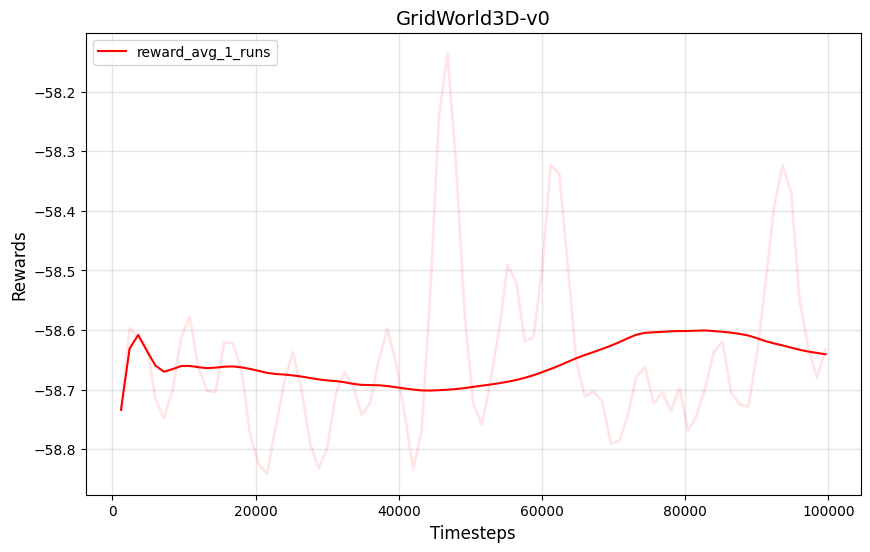

In [15]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

env_name = 'GridWorld3D-v0'

fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)
    
    print("data shape : ", data.shape)
    
    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
        
        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()


